In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
import re
import json
import transformers

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:

# import json
# data_path = "/kaggle/input/arxiv/arxiv-metadata-oai-snapshot.json"
# with open(data_path) as file:
#     lines = file.readlines()
#     # print(lines[0])   # str形式的dict

# paper_item = json.loads(lines[0])
# for key, value in paper_item.items():
#     print(key+" : ", value)

# table
id | title | authors |categories | abs | date| ...(citation)|

In [3]:

# papers = []
# for line in lines:
#     papers.append(json.loads(line))
# papers = pd.DataFrame(papers)
# papers = papers.drop(columns=["comments","journal-ref","doi","report-no", "license"])
# papers.head()

In [4]:

# len(papers)   # 2370685
# import re
# pattern = r"(^|\s)cs\."  # 匹配 "由cs.开头或\space cs. "的模式
# matches = papers["categories"].str.match(pattern, na=False)

# cs_papers = papers[matches]  # len() 462764
# cs_papers["categories"].unique()

In [5]:
# cs_papers_path = "/kaggle/working/cs_papers.json"
# if not os.path.exists(cs_papers_path):
#     cs_papers.to_json(cs_papers_path)

## 考虑利用title和categories训练一个多分类器

### TF-IDF 表示标题特征
(462764, 101910)
TF-IDF生成的矩阵维数太高了，不太行。。。
> 后期可以考虑tokenizer + embbeding 表示为向量

数据分布不太平均，只含1个label的paper含2个label的paper数量的两倍，是含3个label的paper的数量的5倍。
### 训练一个多分类器

In [6]:

# # 需要去除categories中非cs的标签
# # 首先将categories 字符串分割，只保留cs标签
# # 构建 (id) tittle : ["cs.label1", "cs.label2"]
cs_papers_path = "/kaggle/input/mydatasets/cs_papers.json"
with open(cs_papers_path, "r") as f:
        cs_papers = pd.DataFrame(json.load(f))
        
for index, row in cs_papers.iterrows():
    words = row["categories"].split()
    processed_words = [word for word in words if word.startswith('cs.')]
    
    cs_papers.at[index, "categories"] = processed_words

cs_papers.head()

,id,submitter,authors,title,categories,abstract,versions,update_date,authors_parsed
46,0704.0047,Igor Grabec,T. Kosel and I. Grabec,Intelligent location of simultaneously active ...,"[cs.NE, cs.AI]",The intelligent acoustic emission locator is...,"[{'version': 'v1', 'created': 'Sun, 1 Apr 2007...",2009-09-29,"[[Kosel, T., ], [Grabec, I., ]]"
49,0704.0050,Igor Grabec,T. Kosel and I. Grabec,Intelligent location of simultaneously active ...,"[cs.NE, cs.AI]",Part I describes an intelligent acoustic emi...,"[{'version': 'v1', 'created': 'Sun, 1 Apr 2007...",2007-05-23,"[[Kosel, T., ], [Grabec, I., ]]"
61,0704.0062,Tom\'a\v{s} Vina\v{r},"Rastislav \v{S}r\'amek, Bro\v{n}a Brejov\'a, T...",On-line Viterbi Algorithm and Its Relationship...,[cs.DS],"In this paper, we introduce the on-line Vite...","[{'version': 'v1', 'created': 'Sat, 31 Mar 200...",2010-01-25,"[[Šrámek, Rastislav, ], [Brejová, Broňa, ], [V..."
89,0704.0090,Lester Ingber,Lester Ingber,Real Options for Project Schedules (ROPS),"[cs.CE, cs.MS, cs.NA]",Real Options for Project Schedules (ROPS) ha...,"[{'version': 'v1', 'created': 'Sun, 1 Apr 2007...",2007-05-23,"[[Ingber, Lester, ]]"
97,0704.0098,Jack Raymond,"Jack Raymond, David Saad",Sparsely-spread CDMA - a statistical mechanics...,[cs.IT],"Sparse Code Division Multiple Access (CDMA),...","[{'version': 'v1', 'created': 'Sun, 1 Apr 2007...",2009-11-13,"[[Raymond, Jack, ], [Saad, David, ]]"


In [7]:

# title_categories = cs_papers[["title", "categories"]]
# title_categories.head()


In [8]:
title_abs_categories = cs_papers[["title", "abstract","categories"]]
title_abs_categories.head()

,title,abstract,categories
46,Intelligent location of simultaneously active ...,The intelligent acoustic emission locator is...,"[cs.NE, cs.AI]"
49,Intelligent location of simultaneously active ...,Part I describes an intelligent acoustic emi...,"[cs.NE, cs.AI]"
61,On-line Viterbi Algorithm and Its Relationship...,"In this paper, we introduce the on-line Vite...",[cs.DS]
89,Real Options for Project Schedules (ROPS),Real Options for Project Schedules (ROPS) ha...,"[cs.CE, cs.MS, cs.NA]"
97,Sparsely-spread CDMA - a statistical mechanics...,"Sparse Code Division Multiple Access (CDMA),...",[cs.IT]


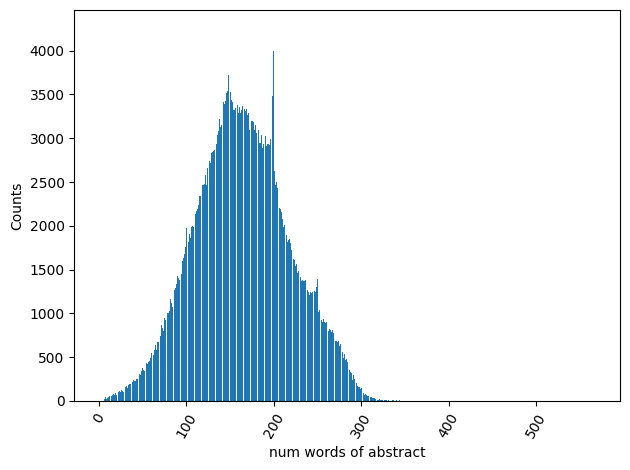

In [9]:
abstract_word_counts = {}
for title in title_abs_categories["abstract"]:
    abstract_parsed = title.split()
    abstract_word_counts[len(abstract_parsed)] = abstract_word_counts.get(len(abstract_parsed), 0) + 1

#for key in sorted(abstract_word_counts.keys()):
#    print("num_words=", key, ": ", abstract_word_counts[key])
# max is ?
    
plt.bar(sorted(abstract_word_counts.keys()), [abstract_word_counts[key] for key in sorted(abstract_word_counts.keys())])
plt.xticks(rotation=60)
plt.xlabel("num words of abstract")
plt.ylabel("Counts")
plt.tight_layout()
plt.show()

In [10]:

# title_categories_path = "/kaggle/working/title_categories.json"
# title_abs_categories_path = "/kaggle/working/title_abs_categories.json"
# if not os.path.exists(title_abs_categories_path):
#     title_abs_categories.to_json(title_abs_categories_path)
# if not os.path.exists(title_categories_path):
#     title_categories.to_json(title_categories_path)

# 从这里开始title-categories的分类

In [11]:
title_categories_path = "/kaggle/input/mydatasets/title_categories.json"

with open(title_categories_path, "r") as f:
    title_categories = pd.DataFrame(json.load(f))
title_categories.head()

,title,categories
46,Intelligent location of simultaneously active ...,"[cs.NE, cs.AI]"
49,Intelligent location of simultaneously active ...,"[cs.NE, cs.AI]"
61,On-line Viterbi Algorithm and Its Relationship...,[cs.DS]
89,Real Options for Project Schedules (ROPS),"[cs.CE, cs.MS, cs.NA]"
97,Sparsely-spread CDMA - a statistical mechanics...,[cs.IT]


{2: 136602, 1: 276364, 3: 40881, 4: 7712, 5: 1174, 7: 3, 6: 28}


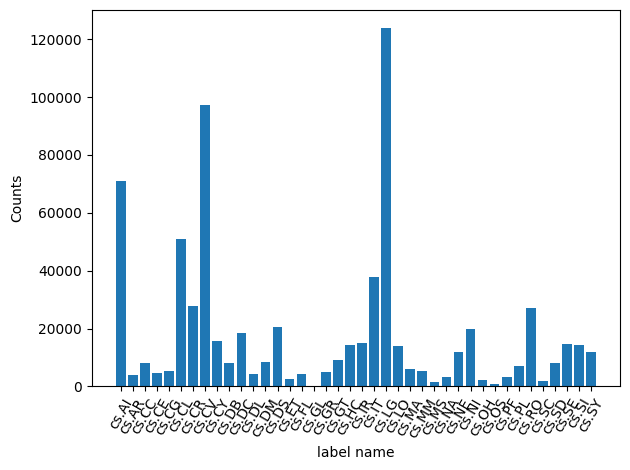

In [12]:
labels_counts = {}
multi_label_counts = {}
for labels in title_categories["categories"]:
    multi_label_counts[len(labels)] = multi_label_counts.get(len(labels), 0) + 1
    for label in labels:
        labels_counts[label] = labels_counts.get(label, 0) + 1

print(multi_label_counts)
label_set = sorted(labels_counts.keys())
# 40 类
plt.bar(label_set, [labels_counts[key] for key in label_set])
plt.xticks(rotation=60)
plt.xlabel("label name")
plt.ylabel("Counts")
plt.tight_layout()
plt.show()


## multi_label_counts：
- num_labels : counts
- 1 :  276364
- 2 :  136602
- 3 :  40881
- 4 :  7712
- 5 :  1174
- 6 :  28
- 7 :  3

绝大多数的paper的label个数在5个以内，大多数在3个以内。

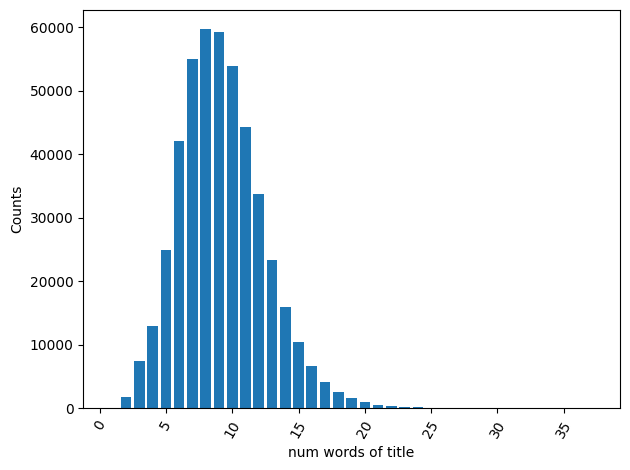

In [13]:
title_word_counts = {}
for title in title_categories["title"]:
    title_parsed = title.split()
    title_word_counts[len(title_parsed)] = title_word_counts.get(len(title_parsed), 0) + 1

#for key in sorted(title_word_counts.keys()):
#    print("num_words=", key, ": ", title_word_counts[key])
# max is 37
    
plt.bar(sorted(title_word_counts.keys()), [title_word_counts[key] for key in sorted(title_word_counts.keys())])
plt.xticks(rotation=60)
plt.xlabel("num words of title")
plt.ylabel("Counts")
plt.tight_layout()
plt.show()
    

In [14]:
one_label, two_label, three_label = [], [], []
for index, row in title_categories.iterrows():
    num_label = len(row["categories"])
    if num_label == 1:
        one_label.append(row)
    elif num_label == 2:
        two_label.append(row)
    elif num_label == 3:
        three_label.append(row)


one_label, two_label, three_label = pd.DataFrame(one_label), pd.DataFrame(two_label), pd.DataFrame(three_label)
print(one_label.head())
print(two_label.head())
print(three_label.head())
sample_size = 30720
sample1 = one_label.sample(sample_size, replace=False)
sample2 = two_label.sample(sample_size, replace=False)
sample3 = three_label.sample(sample_size, replace=False)

                                                 title categories
61   On-line Viterbi Algorithm and Its Relationship...    [cs.DS]
97   Sparsely-spread CDMA - a statistical mechanics...    [cs.IT]
107                              Reducing SAT to 2-SAT    [cs.CC]
212  Geometric Complexity Theory V: On deciding non...    [cs.CC]
216  Capacity of a Multiple-Antenna Fading Channel ...    [cs.IT]
                                                 title      categories
46   Intelligent location of simultaneously active ...  [cs.NE, cs.AI]
49   Intelligent location of simultaneously active ...  [cs.NE, cs.AI]
217  On Almost Periodicity Criteria for Morphic Seq...  [cs.DM, cs.LO]
281  On Punctured Pragmatic Space-Time Codes in Blo...  [cs.IT, cs.CC]
303                  The World as Evolving Information  [cs.IT, cs.AI]
                                                  title             categories
89            Real Options for Project Schedules (ROPS)  [cs.CE, cs.MS, cs.NA]
1027    A neural net

In [15]:
# Load model directly
from transformers import BertModel,BertTokenizer
model_name = "google/bert_uncased_L-2_H-128_A-2"
bert_model = BertModel.from_pretrained(model_name)
tokenizer = BertTokenizer.from_pretrained(model_name)
tokenizer.vocab_size

30522

In [16]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
def make_train_val_data(title_categories:pd.DataFrame, val_radio, label_set, ):

    Binarizer = MultiLabelBinarizer(classes=label_set)
    # 将label列表转换成k-hot形式的multi-labels
    y_multilabels = Binarizer.fit_transform(title_categories["categories"].values)
    print(y_multilabels[0])
    out = tokenizer.batch_encode_plus(title_categories["title"].to_list(), max_length=16,
                                    padding="max_length", truncation=True)
   
    input_ids = np.array(out['input_ids'])
    attention_masks = np.array(out['attention_mask'])
    print(input_ids[0], attention_masks[0])
    x_train, x_val, mask_train, mask_val, y_train, y_val = train_test_split(input_ids, attention_masks, y_multilabels, test_size=val_radio, random_state=49)
    return (x_train, mask_train, y_train), (x_val, mask_val, y_val)


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [17]:
val_radio = 0.2
one_train, one_val = make_train_val_data(sample1, val_radio, label_set)
two_train, two_val = make_train_val_data(sample2, val_radio, label_set)
three_train, three_val = make_train_val_data(sample3, val_radio, label_set)
# train data
x_train = np.concatenate((one_train[0], two_train[0], three_train[0]), axis=0)
mask_train = np.concatenate((one_train[1], two_train[1], three_train[1]), axis=0)
y_train = np.concatenate((one_train[2], two_train[2], three_train[2]), axis=0)
# val data
x_val = np.concatenate((one_val[0], two_val[0], three_val[0]), axis=0)
mask_val = np.concatenate((one_val[1], two_val[1], three_val[1]), axis=0)
y_val = np.concatenate((one_val[2], two_val[2], three_val[2]), axis=0)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
[  101  2006  8536  1011  3132  2779  3446  1997  5292  2099  4160  1011
  2241 16014  2953   102] [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
[ 101 6975 4106 1997 2693 1011 2000 1011 2392 1011 2030 1011 2690 1006
 1049  102] [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 0]
[  101  9844 15756 10425  1024  4651  2013  5038  2000 11061  3945   102
     0     0     0     0] [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0]


In [18]:
class MyDataSet(Dataset):
    def __init__(self, X, masks, y) -> None:
        super().__init__()
        self.X = torch.from_numpy(X).int()
        self.masks = torch.from_numpy(masks).int()
        self.y = torch.from_numpy(y).float()
    
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, index):
        return self.X[index], self.masks[index], self.y[index]

In [19]:
batch_size = 128
train_dataset, val_dataset = MyDataSet(x_train, mask_train, y_train), MyDataSet(x_val, mask_val, y_val)
train_loader, val_loader = DataLoader(train_dataset, batch_size, shuffle=True), DataLoader(val_dataset, batch_size*2, shuffle=True)
print(len(train_dataset), len(val_dataset))

73728 18432


In [20]:
class MyClassifier(nn.Module):
    def __init__(self, num_hidden, num_class):
        super().__init__()
        self.bert = bert_model    # 作为embedding层，进行fine-tuning
        for param in self.bert.parameters():
            param.requires_grad = True
        
        # k cnn-filters k(out_channels)->32
        # 试了一下(16, 32, 48) 32的效果最好
        self.conv1 = nn.Conv2d(1, 48, kernel_size=(3, 128)) # out= in - kernel_size + 1
        self.conv2 = nn.Conv2d(1, 48, kernel_size=(5, 128))
        self.conv3 = nn.Conv2d(1, 48, kernel_size=(7, 128))
        # N,C_out,
        self.pooling = nn.MaxPool2d((3,1), (3,1))
        self.fc1 = nn.Linear(48*12, num_hidden)
        self.act1 = nn.ReLU()
        self.fc2 = nn.Linear(num_hidden, num_hidden)
        self.act2 = nn.ReLU()
        self.fc3 = nn.Linear(num_hidden, num_class)
  
    def forward(self, x, mask):
        # 取bert最后一层隐状态
        out = self.bert(x, attention_mask=mask, token_type_ids=None,)
        last_hidden_state = out["last_hidden_state"]  # N, 16, 128
        #print(hidden_states.shape)
        last_hidden_state.unsqueeze_(1)  # N, 1, 16, 128
        
        out1 = self.conv1(last_hidden_state)  # 16 - 3 + 1
        out2 = self.conv2(last_hidden_state)
        out3 = self.conv3(last_hidden_state)
        out = torch.cat([out1, out2, out3], dim=2)  # N, 32, (14 + 12 + 10 = 36), 1
        out = self.pooling(out)  # N, 32, 12, 1
        #print(out.shape)
        out = out.reshape(out.shape[0], -1)
        #print(out.shape)
        out = self.act1(self.fc1(out))
        out = self.act2(self.fc2(out))
        out = self.fc3(out)
        
        #print(out.shape)
        return out
        

In [21]:
def adaptive_precision(predicts, labels):
    predicts, labels = predicts.to(device), labels.to(device)
    precision = 0.0
    for i in range(labels.shape[0]):
        labels_num, label_ids = torch.sum(labels[i]).item(), torch.nonzero(labels[i]).squeeze()
        # 根据实际label数，选择predict中预测topk
        _, pred_ids = predicts[i].topk(int(labels_num))
        # 计算两组下标相同元素的数目，从而获得precision，并累加
        precision += torch.sum(torch.isin(pred_ids, label_ids)).item() / labels_num
    return precision / labels.shape[0]

def precision_k(predicts, labels, k=3):
    """
    predicts : (batch_size, C)
    labels : (batch_size, C)  {0, 1}^C
    """
    predicts, labels = predicts.to(device), labels.to(device)
    _, topk_pred_ids = predicts.topk(k, dim=1)  # batch_size, k

    precision_rank_k = torch.zeros(labels.shape[0]).to(device) # batch_size,
    
    for pred_ids in topk_pred_ids.T:
        precision_rank_k += labels[torch.arange(labels.shape[0]), pred_ids]
        
    return precision_rank_k / k

def topk_eval(net, top_k:list, val_loader, metric=precision_k):
    net.eval()
    correct_topk = torch.zeros(len(top_k))
    with torch.no_grad():
        for x, mask, y in val_loader:
            x, mask = x.to(device), mask.to(device)
            outputs = net(x, mask)
            for i, k in enumerate(top_k):
                correct_topk[i] += metric(outputs, y, k).mean().item()
    
    return correct_topk / len(val_loader)

def actual_eval(net, val_loader, metric):
    net.eval()
    correct = 0.0
    with torch.no_grad():
        for x, mask, y in val_loader:
            x, mask = x.to(device), mask.to(device)
            outputs = net(x, mask)
            correct += metric(outputs, y)
                   
    return correct / len(val_loader)
    

In [22]:
from transformers import get_scheduler
model = MyClassifier(num_hidden=256 ,num_class=40)
# optimizer = optim.Adam(model.parameters(), lr=1e-3)
optimizer = optim.AdamW(model.parameters(), lr=1e-4) #fine-tuning bert
criterion = nn.BCEWithLogitsLoss()
num_epochs = 5
num_training_steps = num_epochs * len(train_loader)

lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, 
    num_training_steps=num_training_steps)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

MyClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-1): 2 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=128, out_features=128, bias=True)
              (key): Linear(in_features=128, out_features=128, bias=True)
              (value): Linear(in_features=128, out_features=128, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=128, out_features=128, bias=True)
              (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine

In [23]:
from tqdm.auto import tqdm

progress_bar = tqdm(range(num_training_steps))

top_k = [1, 2, 3]
actual = True
log_num = 1
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    for x, mask, y in train_loader:
        optimizer.zero_grad()
        outputs = model(x.to(device), mask.to(device))
        loss = criterion(outputs.to(device), y.to(device))
        #with torch.autograd.set_detect_anomaly(True):
        loss.backward()
        epoch_loss += loss.item()
        optimizer.step()
        lr_scheduler.step()
        
        progress_bar.update(1)
    if (epoch + 1)% log_num == 0:
        print(f"[Train]: {epoch + 1}/{num_epochs}, Loss: {epoch_loss/len(train_loader)}")
    
        precisions = topk_eval(model, top_k, val_loader=val_loader)
        for i, k in enumerate(top_k):    
            print(f"P@{k}={precisions[i].item()*100:.4f}%")
        if actual:   # 根据实际label数目计算的precision
            actual_precison = actual_eval(model, val_loader, metric=adaptive_precision)
            print(f"adapted_P={actual_precison*100:.4f}%")



  0%|          | 0/2880 [00:00<?, ?it/s]

[Train]: 1/5, Loss: 0.17271502242268374
P@1=51.6222%
P@2=43.1234%
P@3=36.3227%
adapted_P=45.1163%
[Train]: 2/5, Loss: 0.12238082478547262
P@1=65.1096%
P@2=51.5706%
P@3=42.5420%
adapted_P=55.4046%
[Train]: 3/5, Loss: 0.10879214012271
P@1=68.2129%
P@2=54.0392%
P@3=44.4969%
adapted_P=58.3704%
[Train]: 4/5, Loss: 0.10330194146889779
P@1=69.4499%
P@2=55.0429%
P@3=45.1678%
adapted_P=59.4437%
[Train]: 5/5, Loss: 0.10080024455156592
P@1=69.6994%
P@2=55.1622%
P@3=45.4319%
adapted_P=59.7295%


In [24]:
def predict_categories(model, titles:list[str], label_set=label_set, tokenizer=tokenizer):
    num_papers = len(titles)
    pred_categories = {}
    model.cpu()
    model.eval()
    out = tokenizer.batch_encode_plus(titles, max_length=16,
                                  padding="max_length", truncation=True)
    token_ids, attn_masks = out["input_ids"], out["attention_mask"]
    # 转为tensor，
    token_ids = torch.tensor(token_ids).int()
    attn_masks = torch.tensor(attn_masks).int()

    with torch.no_grad():
        for i in range(num_papers):
            # 添加batch_size维度
            x, mask = token_ids[i].unsqueeze_(0), attn_masks[i].unsqueeze_(0)
            output = model(x, mask)
            # 获取top3的标签
            _, pred_ids = output.topk(k=3)
            
            pred_categories[titles[i]] = [label_set[ids.item()] for ids in pred_ids.squeeze(0)]

    return pred_categories

In [25]:
with open("/kaggle/input/mydatasets/test_t_c.json") as f:
    test_t_c = json.load(f)
    
test_t_c = pd.DataFrame([[k, v] for k, v in test_t_c.items()], columns=["title", "categories"])
    
for index, row in test_t_c.iterrows():
    words = row["categories"]
    processed_words = [word for word in words if word.startswith('cs.')]
    
    test_t_c.at[index, "categories"] = processed_words
test_t_c[50:60]

,title,categories
50,Abstract Stobjs and Their Application to ISA M...,"[cs.LO, cs.AR, cs.SC]"
51,A Cognitive Science perspective for learning h...,"[cs.AI, cs.CY, cs.HC]"
52,CS-Insights: A System for Analyzing Computer S...,"[cs.CL, cs.DL]"
53,Real-number Computability from the Perspective...,"[cs.LO, cs.CC]"
54,Algebraic recognizability of languages,[cs.LO]
55,An Effective Extension of the Wagner Hierarchy...,"[cs.LO, cs.FL]"
56,Sequentiality vs. Concurrency in Games and Logic,[cs.LO]
57,Physics and computer science: quantum computat...,[]
58,Typed Operational Semantics for Dependent Reco...,[cs.LO]
59,Is Machine Learning Unsafe and Irresponsible i...,"[cs.CY, cs.AI]"


In [26]:
test_titles = test_t_c["title"].to_list()[20:30]
# test_titles = ["LayerCollapse: Adaptive compression of neural networks"]
pred_categories = predict_categories(model, titles=test_titles, label_set=label_set, tokenizer=tokenizer)
for k, v in pred_categories.items():
    print(k, ": ", v)

A short proof that adding some permutation rules to $β$ preserves $SN$ :  ['cs.LO', 'cs.CC', 'cs.DM']
Distributed Games and Strategies :  ['cs.GT', 'cs.DS', 'cs.MA']
Tripartite Unions :  ['cs.GT', 'cs.DS', 'cs.DM']
Cloudifying the Curriculum with AWS :  ['cs.DC', 'cs.AR', 'cs.PF']
Tarski's influence on computer science :  ['cs.CY', 'cs.SI', 'cs.HC']
Saying Hello World with MOLA - A Solution to the TTC 2011 Instructive Case :  ['cs.IR', 'cs.SE', 'cs.HC']
Oxford-style Debates in Telecommunication and Computer Science Education :  ['cs.CL', 'cs.CY', 'cs.AI']
Motivation, Design, and Ubiquity: A Discussion of Research Ethics and Computer Science :  ['cs.CY', 'cs.SI', 'cs.HC']
Complex Workflow Management and Integration of Distributed Computing Resources by Science Gateway Portal for Molecular Dynamics Simulations in Materials Science :  ['cs.DC', 'cs.NI', 'cs.SE']
Addressing Hate Speech with Data Science: An Overview from Computer Science Perspective :  ['cs.CL', 'cs.CY', 'cs.AI']
